In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew
from scipy.stats import norm
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

Let's load the train set and extract a test set

In [144]:
train = pd.read_csv('./dataset/preprocessed_train.csv')
train.head()

,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,NumberOfCustomers,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,1000,2016-03-01,0,1,0,Hyper Market,General,326,7,495,...,0,1,0,0,1,0,0,1,0,0
1,1000,2016-03-02,0,1,0,Hyper Market,General,326,7,608,...,0,0,1,0,1,0,0,1,0,0
2,1000,2016-03-04,0,1,0,Hyper Market,General,326,7,665,...,0,0,0,0,1,0,0,1,0,0
3,1000,2016-03-05,0,1,0,Hyper Market,General,326,7,630,...,0,0,0,0,1,0,0,1,0,0
4,1000,2016-03-07,0,1,1,Hyper Market,General,326,7,763,...,0,0,0,0,1,0,0,1,0,0


let's consider only the valid and useful attributes for regression

In [145]:
#removed_attr=['Date', 'IsOpen', 'StoreType','AssortementType','Events']
train = train.drop(['StoreID','Date', 'IsOpen', 'StoreType','AssortmentType','Events','Day_of_week','Region'], axis=1)
train.head()

,IsHoliday,HasPromotions,NearestCompetitor,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,0,0,326,495,5676,9643,17130,2770,8.0,1,...,0,1,0,0,1,0,0,1,0,0
1,0,0,326,608,8111,9643,17130,2770,8.0,0,...,0,0,1,0,1,0,0,1,0,0
2,0,0,326,665,8300,9643,17130,2770,8.0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,0,326,630,7154,9643,17130,2770,6.0,-3,...,0,0,0,0,1,0,0,1,0,0
4,0,1,326,763,10110,9643,17130,2770,0.0,-2,...,0,0,0,0,1,0,0,1,0,0


In [146]:
train.shape[0]

433926

let's extract a test set for evaluation purpose'

In [147]:
X_train = train.drop(['NumberOfCustomers', 'NumberOfSales'], axis=1)
y = train['NumberOfSales']
from sklearn import preprocessing
y = (y - y.mean())/y.std()
y.head()

0    0.354636
1    1.453915
2    1.539239
3    1.021878
4    2.356363
Name: NumberOfSales, dtype: float64

In [127]:
X_train.head()

,IsHoliday,HasPromotions,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Humidity,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,0,0,326,7,9643,17130,2770,8.0,1,100,...,0,1,0,0,1,0,0,1,0,0
1,0,0,326,7,9643,17130,2770,8.0,0,87,...,0,0,1,0,1,0,0,1,0,0
2,0,0,326,7,9643,17130,2770,8.0,0,81,...,0,0,0,0,1,0,0,1,0,0
3,0,0,326,7,9643,17130,2770,6.0,-3,80,...,0,0,0,0,1,0,0,1,0,0
4,0,1,326,7,9643,17130,2770,0.0,-2,93,...,0,0,0,0,1,0,0,1,0,0


Linear Regression Models.

Now we are going to use plain linear regressio and regularized models (both l_1 Lasso and l_2 Ridge) from the scikit learn module. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [137]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


def r2_cv(model, X_train, y, random_state=12345678):
    r2= cross_val_score(model, X_train, y, scoring="r2", cv =KFold(10, shuffle=True, random_state=random_state))
    return(r2)

def rmse_cv(model, X_train, y, random_state=12345678):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv =KFold(10, shuffle=True, random_state=random_state)))
    return(rmse)

In [138]:
model_simple = LinearRegression()
model_simple.fit(X_train, y)
yp = model_simple.predict(X_train)




# compute R2 for train and using crossvalidation
r2_simple_train = r2_score(y,yp)
r2_xval_simple =  r2_cv(model_simple, X_train, y)

# compute RMSE for train and using crossvalidation
rmse_simple_train = mean_squared_error(y,yp,multioutput='raw_values')
rmse_xval_simple =  rmse_cv(model_simple, X_train, y)

print("Linear Regression")
print("==================================================")
print("\t                  Train R2=%.3f"%(r2_simple_train))
print("\t10-fold Crossvalidation R2=%.3f"%(r2_xval_simple.mean()))
print("\t                  Train RMSE=%.3f"%(rmse_simple_train))
print("\t10-fold Crossvalidation RMSE=%.3f"%(rmse_xval_simple.mean()))

Linear Regression
	                  Train R2=0.235
	10-fold Crossvalidation R2=0.235
	                  Train RMSE=0.765
	10-fold Crossvalidation RMSE=0.875


In [139]:
yp.head()


AttributeError: 'numpy.ndarray' object has no attribute 'head'

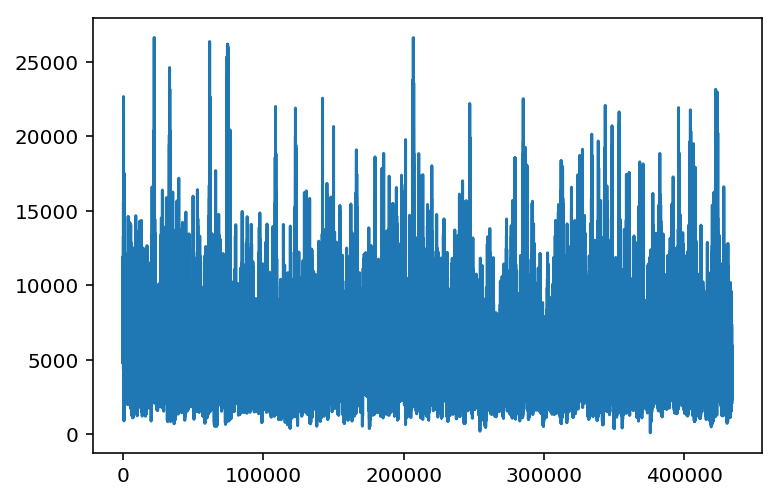

In [117]:
plt.plot(y)

## Ridge Regression
We now try ridge regression (l_2) and for this purpose we need to select a value of \alpha. The higher the \alpha, the higher the penalization of weights with a large absolute value. We select a possible range of values of \alpha and apply ridge for each value.

In [91]:
alphas = [0.05, 0.1, 0.3]
cv_ridge = [rmse_cv(Ridge(alpha = alpha, normalize=True), X_train, y).mean() for alpha in alphas]
cv_r2_ridge = [r2_cv(Ridge(alpha = alpha), X_train, y).mean() for alpha in alphas]

C:\Users\Utente\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1378166241766916e-32 / 1.1102230246251565e-16
  RuntimeWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\scipy\linalg\basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1915978308480454e-32 / 1.1102230246251565e-16
  RuntimeWarning)


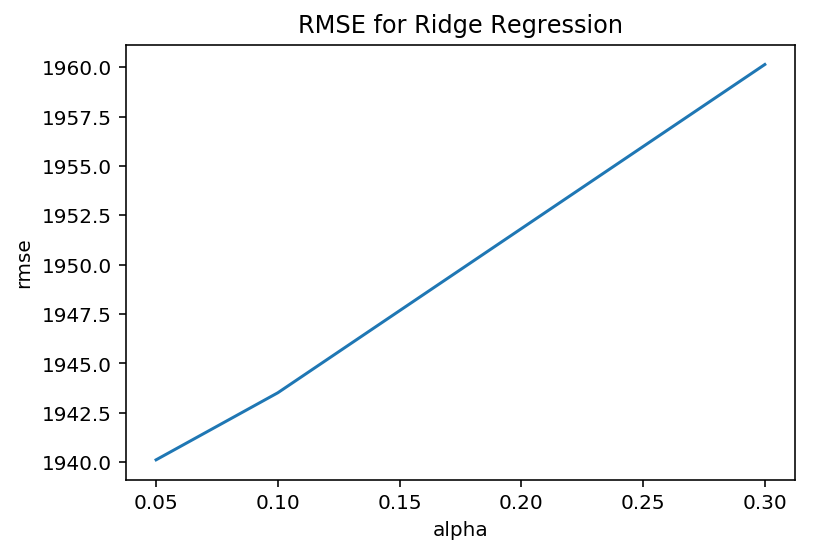

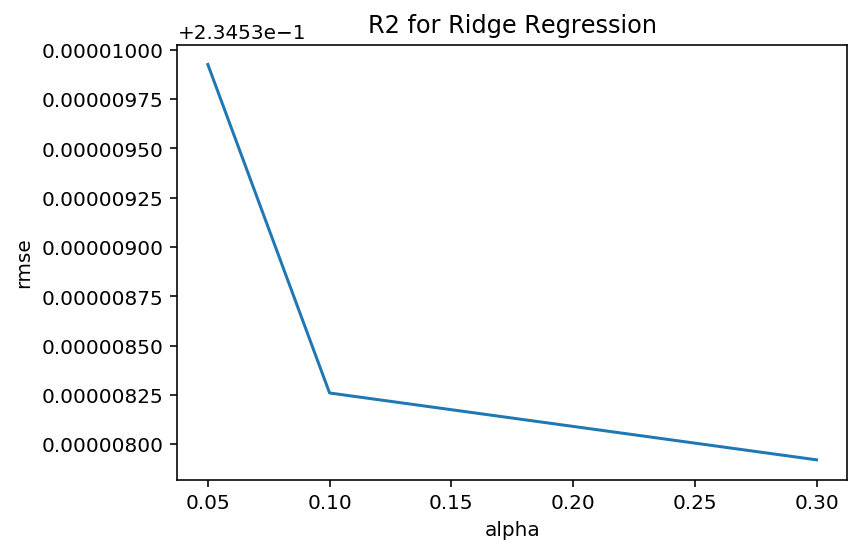

In [92]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_r2_ridge = pd.Series(cv_r2_ridge, index = alphas)

cv_ridge.plot(title = "RMSE for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

cv_r2_ridge.plot(title = "R2 for Ridge Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()


In [93]:
print("Best RMSE %.3f for alpha %.3f"%(cv_ridge.min(),cv_ridge.idxmin()))
print("Best R2 %.3f for alpha %.3f"%(cv_r2_ridge.max(),cv_r2_ridge.idxmax()))
#print("Why the difference? R2[10]=%.6f R2[15]=%.6f"%(cv_r2_ridge[cv_ridge.idxmin()],cv_r2_ridge[cv_r2_ridge.idxmax()]))

Best RMSE 1940.111 for alpha 0.050
Best R2 0.235 for alpha 0.050


## Lasso Regression ($L_1$)
We now test Lasso regression. As before we need to test different values of \alpha. Let' try out the Lasso model. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [ ]:
alphas = [1]
cv_lasso = [rmse_cv(Lasso(alpha = alpha, tol= 100), X_train, y).mean() for alpha in alphas]
cv_r2_lasso = [r2_cv(Lasso(alpha = alpha), X_train, y).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_r2_lasso = pd.Series(cv_r2_lasso, index = alphas)

plt.figure(figsize=(6,4))
cv_lasso.plot(title = "RMSE for Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

plt.figure(figsize=(6,4))
cv_r2_lasso.plot(title = "R2 for Lasso Regression")
plt.xlabel("alpha")
plt.ylabel("R2")
plt.show()

C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [99]:
train.head(2)

,IsHoliday,HasPromotions,NearestCompetitor,Region,NumberOfCustomers,NumberOfSales,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Is_Thursday,Is_Tuesday,Is_Wednesday,StoreType_SuperMarket,StoreType_HyperMarket,StoreType_StandardMarket,StoreType_ShoppingCenter,AssortmentType_General,AssortmentType_WithNFDept,AssortmentType_WithFishDept
0,0,0,326,7,495,5676,9643,17130,2770,8.0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,326,7,608,8111,9643,17130,2770,8.0,...,0,0,1,0,1,0,0,1,0,0
